In [1]:
import numpy as np
import scipy.io as scio # load mat file
from scipy.signal import welch, filtfilt
from scipy.interpolate import interp1d

from PSO import *  # demo PSO codes!

import matplotlib.pyplot as plt

In [2]:
# load data
TrainingData = scio.loadmat('TrainingData.mat') # only noise    
analysisData = scio.loadmat('analysisData.mat') # noise + signal
# analysisData = scio.loadmat('TrainingData.mat') # only noise to check

## Preparing
dataY = analysisData['dataVec'][0] # (2048,)
# dataY = analysisData['trainData'][0] # (2048,)
# Data length
nSamples = dataY.size # 2048
# Sampling frequency
Fs = analysisData['sampFreq'][0,0] # 1024
# Fs = 1024

# Search range of phase coefficients
rmin = [40, 1, 1]
rmax = [100, 50, 15]

# Noise realization: PSD estimated from TrainingData
dt = 1/Fs
t = np.arange(0, nSamples*dt, dt) # (2048,)
T = nSamples/Fs
df = 1/T
Nyq = Fs/2 # Nyquist frequency
[f, pxx] = welch(TrainingData['trainData'][0], fs=Fs, 
                 window='hamming', nperseg=Fs/2, 
                 noverlap=None, nfft=None, 
                 detrend=False) 
# Why 'detrend=False'? 
# See https://github.com/scipy/scipy/issues/8045#issuecomment-337319294
# or https://iphysresearch.github.io/blog/post/signal_processing/spectral_analysis_scipy/

# Smooth the PSD estimate
smthOrdr = 10
b = np.ones(smthOrdr)/smthOrdr
pxxSmth = filtfilt(b,1,pxx)
# PSD must be supplied at DFT frequencies.
kNyq = np.floor(nSamples/2) + 1
posFreq = np.arange(0, kNyq)*Fs/nSamples
psdPosFreq = interp1d(f,pxxSmth)(posFreq)

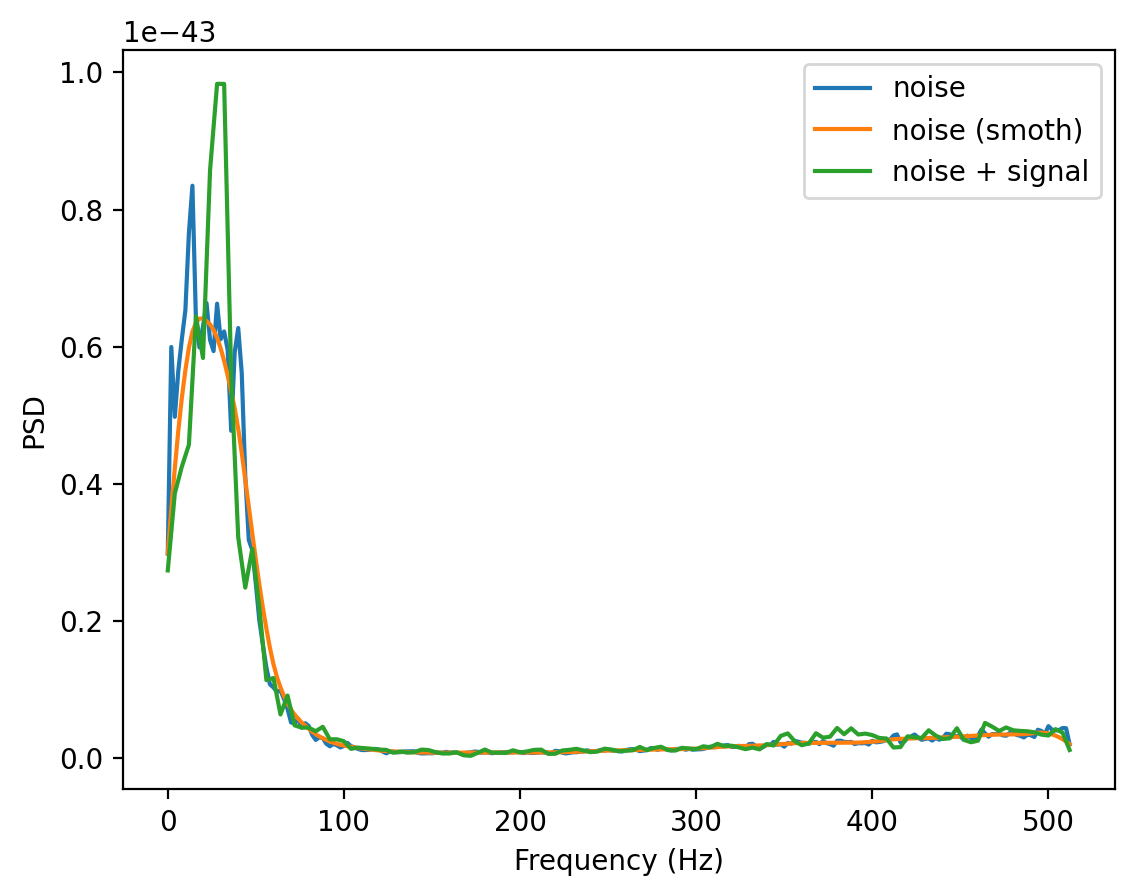

In [3]:
# Plot PSDs for the noise and noise + signal.
plt.figure(dpi=200)
plt.plot(f,pxx, label='noise')
plt.plot(f,pxxSmth, label='noise (smoth)')
[f, pxxY] = welch(dataY, fs=Fs, 
                 window='hamming', nperseg=256, 
                 noverlap=None, nfft=None, 
                 detrend=False)
plt.plot(f,pxxY, label='noise + signal')
plt.xlabel('Frequency (Hz)')
plt.ylabel('PSD')
plt.legend()
plt.savefig('output_psd.png', dpi=200)
plt.show()

In [4]:
# Number of independent PSO runs
nRuns = 8

In [5]:
# calculate Amplitude of the signal (changed by ywq)
deita = np.std(TrainingData['trainData'][0])
dataYmax = np.max(dataY)
dataYmin = np.min(dataY)
A = (dataYmax - dataYmin) / 2
A_signal = np.sqrt(A ** 2 - deita ** 2)
print("振幅为：", A_signal)

振幅为： 5.600985972378616e-21


In [6]:
## PSO
# Input parameters for CRCBQCHRPPSO
inParams = {
    'dataX': t,
    'dataY': dataY,
    'dataXSq': t**2,
    'dataXCb': t**3,
    'psdPosFreq': psdPosFreq,
    'sampFreq': Fs,
    'rmin': rmin,
    'rmax': rmax,
    'A': A_signal,
    'noise':TrainingData['trainData'][0],
}
# CRCBQCHRPPSOPSD runs PSO on the CRCBQCHRPFITFUNC fitness function. As an
# illustration of usage, we change one of the PSO parameters from its
# default value.
outResults, outStruct = crcbqcpsopsd(inParams, {'maxSteps': 2000}, nRuns)

Overall Progress:   0%|          | 0/8 [00:00<?, ?it/s]












































































































































100%|██████████| 2000/2000 [00:14<00:00, 139.20it/s]

Overall Progress:  12%|█▎        | 1/8 [00:14<01:40, 14.42s/it]




Overall Progress:  25%|██▌       | 2/8 [00:14<00:36,  6.04s/it]




100%|██████████| 2000/2000 [00:14<00:00, 136.31it/s]









100%|██████████| 2000/2000 [00:14<00:00, 136.07it/s]  3.34s/it]









100%|██████████| 2000/2000 [00:14<00:00, 140.88it/s]






100%|██████████| 2000/2000 [00:14<00:00, 138.90it/s]  5.47s/it]





100%|██████████| 2000/2000 [00:14<00:00, 139.04it/s]







100%|██████████| 2000/2000 [00:16<00:00, 121.37it/s]  3.07s/it]




Overall Progress: 100%|██████████| 8/8 [00:30<00:00,  3.87s/it]

第0次循环SNR结果: 8.73994402374927
第1次循环SNR结果: -13.095599177627362
第2次循环SNR结果: -41.049736827996135
第3次循环SNR结果: -7.102003904468917
第4次循环SNR结果: 12.030280029316602
第5次循环SNR结果: -12.166473423708494
第6次循环SNR结果: -9.959441958605412
第7次循环SNR结果: -30.744674566027214
传递的snr: 12.030280029316602
传递接收到的snr: 12.030280029316602


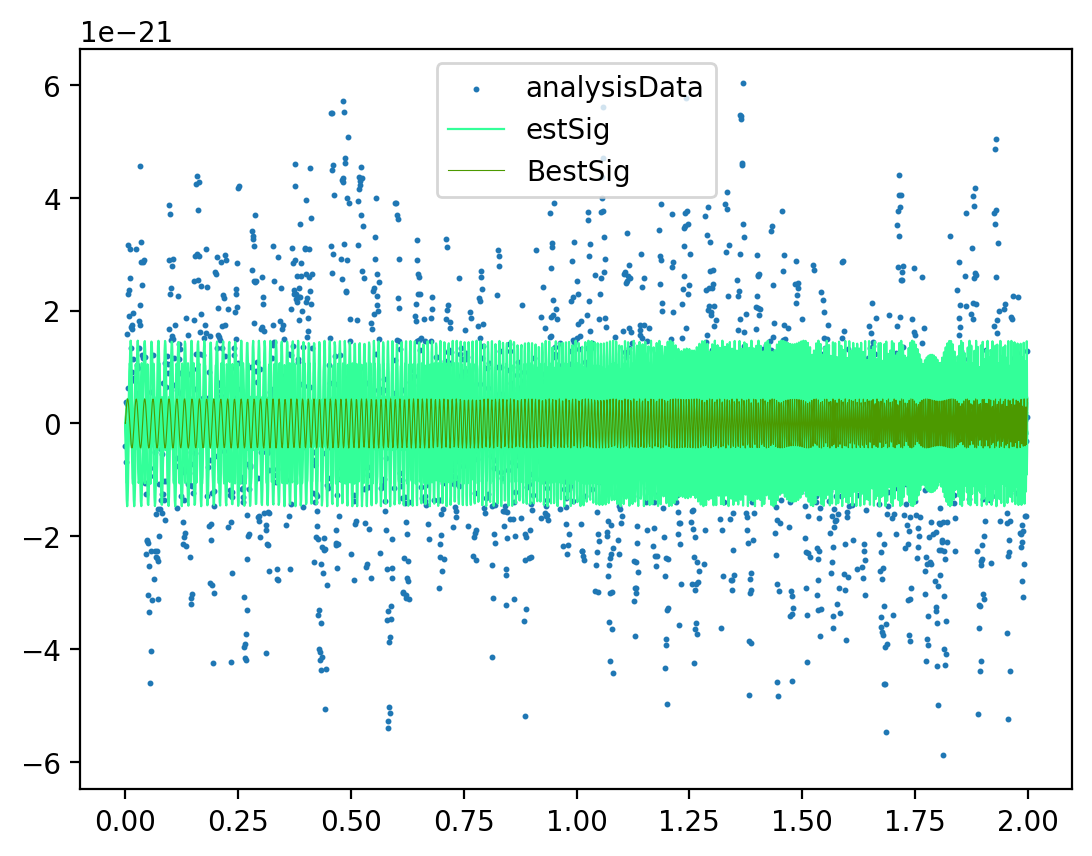

[-0.00000000e+00 -4.77794945e-22 -8.54785607e-22 ...  7.54825950e-22
 -9.05421564e-22 -3.49493567e-22]


In [7]:
## Plots
fig = plt.figure(dpi=200)
ax = fig.add_subplot(111)
a=ax.scatter(t, dataY, marker='.', s=5, #label='analysisData'
             )
a.set_label('analysisData')
for lpruns in range(nRuns):
    b,=ax.plot(t, outResults['allRunsOutput'][lpruns]['estSig'],
             color=[51/255,255/255,153/255], lw=.4*2)
b.set_label('estSig')
c,=ax.plot(t, outResults['bestSig'], #label='BestSig',
         color=[76/255,153/255,0/255],lw=.2*2)
c.set_label('BestSig')
plt.legend()
plt.savefig('output_sig.png', dpi=200)
plt.show()
print(outResults['allRunsOutput'][lpruns]['estSig'])

In [8]:
# Print estimated parameters
print('Estimated parameters: a1={}; a2={}; a3={}'.format(outResults['bestQcCoefs'][0],
                                                         outResults['bestQcCoefs'][1],
                                                         outResults['bestQcCoefs'][2]),
                                    # '\nbestSNR= {:.4f}'.format(outResults['bestSNR'])
                                    # '\nestAmp = {}'.format(outResults['bestAmp'])
                                    )
print('\nbestSNR=',outResults['bestSNR'])
for lpruns in range(nRuns):
    print('\nRun No.{}:\nbestFitness={:.2f}'.format(lpruns+1, outStruct[lpruns]['bestFitness']))   
    print('a1={:.4f}; a2={:.4f}; a3={:.4f}'.format(outResults['allRunsOutput'][lpruns]['qcCoefs'][0],
                                       outResults['allRunsOutput'][lpruns]['qcCoefs'][1],
                                       outResults['allRunsOutput'][lpruns]['qcCoefs'][2]))
# Save
np.save('output_results',outResults)
np.save('output_struct',outStruct)

Estimated parameters: a1=51.3605915101784; a2=28.832078856931652; a3=10.308191421692223

bestSNR= 12.030280029316602

Run No.1:
bestFitness=-36.77
a1=52.7682; a2=27.6158; a3=10.6322

Run No.2:
bestFitness=-24.73
a1=56.9549; a2=22.9196; a3=12.1866

Run No.3:
bestFitness=-20.99
a1=63.5777; a2=18.1104; a3=13.3390

Run No.4:
bestFitness=-28.01
a1=46.1993; a2=32.1370; a3=9.6517

Run No.5:
bestFitness=-41.01
a1=51.3606; a2=28.8321; a3=10.3082

Run No.6:
bestFitness=-20.35
a1=73.1083; a2=14.2284; a3=13.4995

Run No.7:
bestFitness=-24.72
a1=55.5727; a2=23.9883; a3=11.9527

Run No.8:
bestFitness=-18.23
a1=75.5552; a2=11.6662; a3=14.2448
